In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam, Adam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy
import ntpath

import tensorflow as tf

K.clear_session()
K.set_image_dim_ordering('tf')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)




def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    return loss

def unet_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true,y_pred) - K.log(jaccard_coef(y_true,y_pred))
    return loss

In [3]:
def preprocessmask(gray):
    ret, gray = cv2.threshold(gray, 200, 255,0)
    imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    #x,y,w,h = cv2.boundingRect(largest_areas[-1])
    mask = np.zeros((512,512),dtype= np.uint8)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    return mask

In [4]:
model = load_model('accunetnew.h5', custom_objects={'unet_loss': unet_loss})

In [5]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """    
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [6]:
import glob
import ntpath
count= ""
image_size = 512
orig_path = "/home/ubuntu/research/train/btrain/*"
output_overlay_path = "/home/ubuntu/research/train/overlayfour/"
orig = glob.glob(orig_path)
for fl in orig:
    count = fl
    orig_images= cv2.imread(fl)
    orig_images = cv2.resize(orig_images, (512, 512))
    image = np.expand_dims(orig_images, axis=0)
    mpo = model.predict(image)
    a = np.uint8(mpo*255)
    gray = a.reshape(512,512)
    k=preprocessmask(gray)
    final_overlay = mask_overlay(orig_images, (k > 0.5).astype(np.uint8))
    basenm = ntpath.basename(fl)
    nm_output_mask = output_overlay_path+basenm
    cv2.imwrite(nm_output_mask,final_overlay)

In [ ]:
largest_areas=[]
def preprocessmask(gray):
    global largest_areas
    ret, gray = cv2.threshold(gray, 250, 255,0)
    imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    #x,y,w,h = cv2.boundingRect(largest_areas[-1])
    mask = np.zeros((512,512),dtype= np.uint8)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    return mask

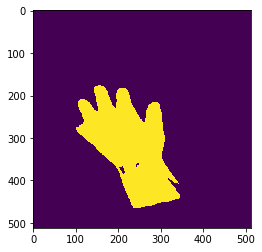

In [6]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/3812.png")
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = model.predict(image)
a = np.uint8(mpo*255)
gray = a.reshape(512,512)
ret, gray = cv2.threshold(gray, 140, 255,0)
imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
plt.imshow(gray)
plt.show()

In [7]:
plt.imshow(final_overlay)
plt.show()

NameError: name 'final_overlay' is not defined

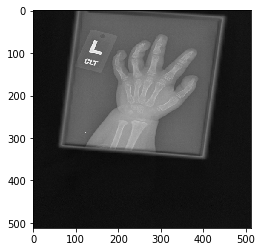

In [6]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/1399.png")
orig_images = cv2.resize(orig_images, (512, 512))
plt.imshow(orig_images)
plt.show()

(1293, 945, 3)


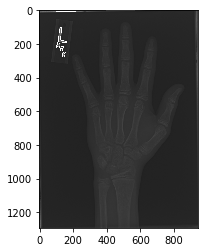

True

In [6]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/3124.png")
print(orig_images.shape)
#orig_images = cv2.resize(orig_images, (512, 512))
plt.imshow(orig_images)
plt.show()
cv2.imwrite("outputforml/1.png",orig_images)

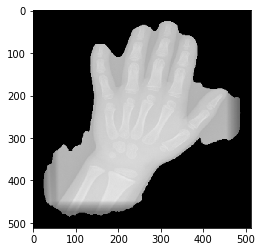

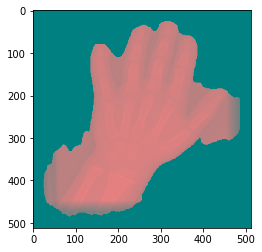

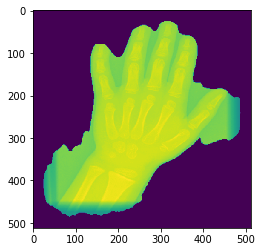

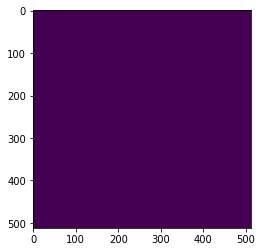

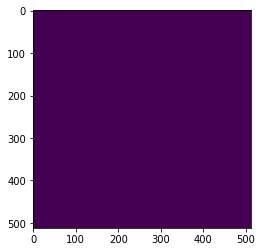

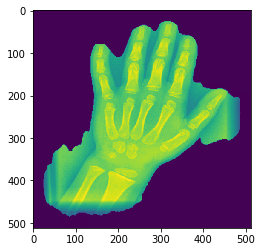

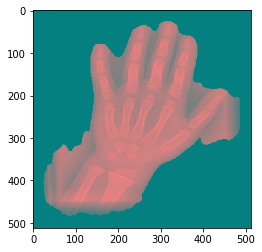

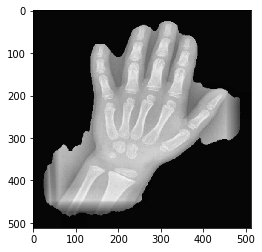

In [34]:
# 1381 1418 1469 1478
orig_images = cv2.imread('train/btrain/1429.png')
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = model.predict(image)
a = np.uint8(mpo*255)
a = a.reshape(512,512,1)

ret, gray = cv2.threshold(a, 200, 255,0)
image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_areas[-1])
mask = np.zeros((512,512),dtype= np.uint8)
cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
roi=image[y-20:y+h+20,x-20:x+w+20]
roi=cv2.resize(roi,(512,512))
plt.imshow(roi)
plt.show()
#cv2.imwrite()
lab= cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
plt.imshow(lab)
plt.show()
#cv2.imwrite("outputforml/1_lab.png",lab)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)
plt.show()

plt.imshow(a)
plt.show()

plt.imshow(b)

plt.show()
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
plt.imshow( cl)
plt.show()
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)
plt.show()
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
plt.imshow(final)
#plt.show()

In [18]:
shapey

(1293, 945, 3)

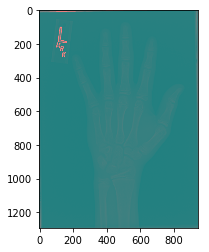

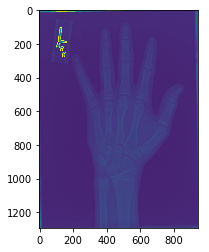

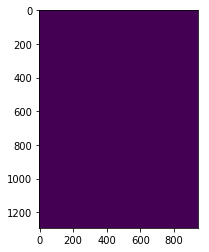

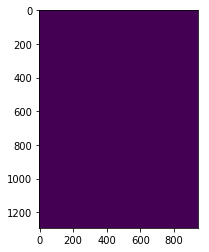

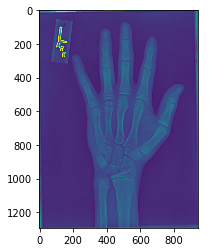

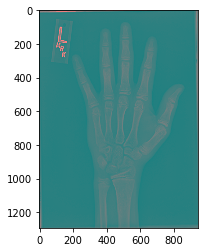

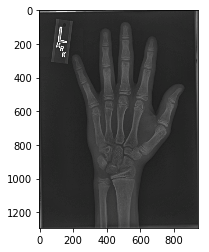

In [35]:
orig_images = cv2.imread('train/btrain/3124.png')
shapey = orig_images.shape
orig_images = cv2.resize(orig_images, (512, 512))
lab= cv2.cvtColor(orig_images, cv2.COLOR_BGR2LAB)
plt.imshow( cv2.resize(lab, (shapey[1], shapey[0])))
cv2.imwrite('train/outputforimage/lab.png', cv2.resize(lab, (shapey[1], shapey[0])))
plt.show()
#cv2.imwrite("outputforml/1_lab.png",lab)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow( cv2.resize(l, (shapey[1], shapey[0])))
cv2.imwrite('train/outputforimage/l.png', cv2.resize(l, (shapey[1], shapey[0])))
plt.show()
plt.imshow( cv2.resize(a, (shapey[1], shapey[0])))
cv2.imwrite('train/outputforimage/a.png', cv2.resize(a, (shapey[1], shapey[0])))
plt.show()
plt.imshow( cv2.resize(b, (shapey[1], shapey[0])))
cv2.imwrite('train/outputforimage/b.png', cv2.resize(b, (shapey[1], shapey[0])))

plt.show()
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
cv2.imwrite('train/outputforimage/cl.png', cv2.resize(cl, (shapey[1], shapey[0])))
plt.imshow( cv2.resize(cl, (shapey[1], shapey[0])))
plt.show()
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
cv2.imwrite('train/outputforimage/ling.png', cv2.resize(limg, (shapey[1], shapey[0])))
plt.imshow( cv2.resize(limg, (shapey[1], shapey[0])))
plt.show()
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
cv2.imwrite('train/outputforimage/final_input.png', cv2.resize(final, (shapey[1], shapey[0])))
plt.imshow( cv2.resize(final, (shapey[1], shapey[0])))
plt.show()

In [36]:
image = np.expand_dims(final, axis=0)
mpo = model.predict(image)


In [37]:

a = np.uint8(mpo*255)


In [38]:
gray = a.reshape(512,512)


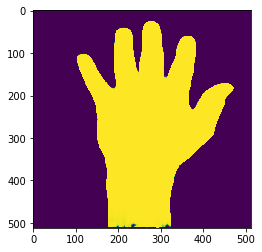

In [39]:
plt.imshow(gray)
cv2.imwrite('train/outputforimage/mask.png', cv2.resize(gray, (shapey[1], shapey[0])))
plt.show()

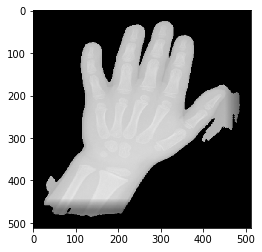

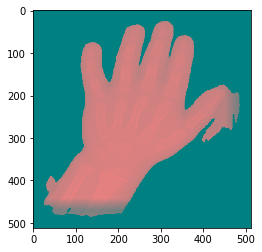

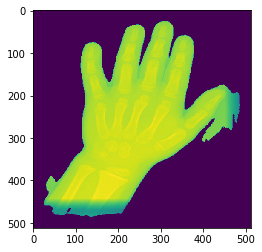

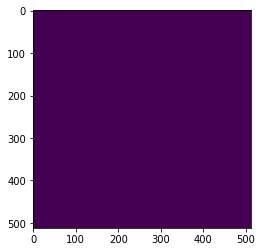

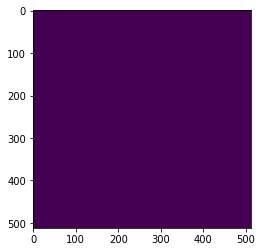

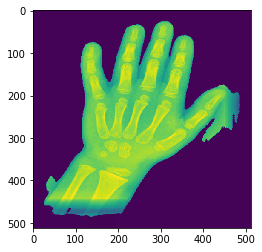

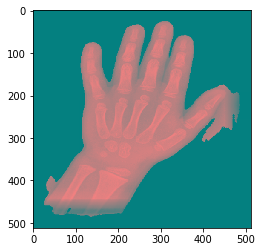

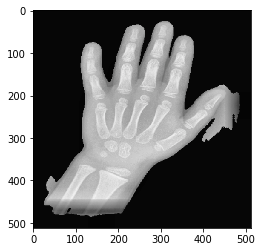

In [40]:
# 1381 convert to clahe

a = a.reshape(512,512,1)

ret, gray = cv2.threshold(a, 200, 255,0)
image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_areas[-1])
mask = np.zeros((512,512),dtype= np.uint8)
cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
roi=image[y-20:y+h+20,x-20:x+w+20]
roi=cv2.resize(roi,(512,512))
plt.imshow(roi)
plt.show()

lab= cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
plt.imshow(lab)
plt.show()
#cv2.imwrite("outputforml/1_lab.png",lab)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)
plt.show()

plt.imshow(a)
plt.show()

plt.imshow(b)

plt.show()
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
plt.imshow( cl)
plt.show()
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)
plt.show()
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
plt.imshow(final)
#plt.show()

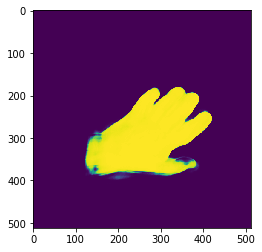

In [33]:
plt.imshow(gray)
plt.show()

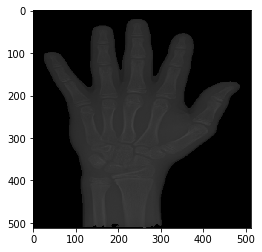

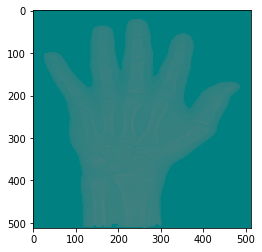

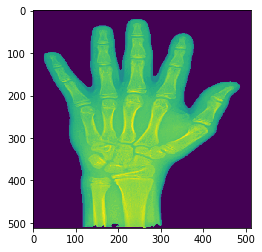

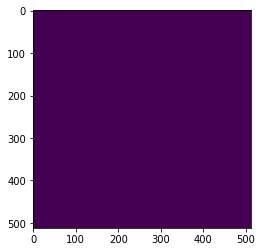

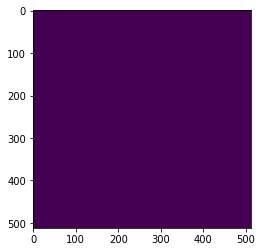

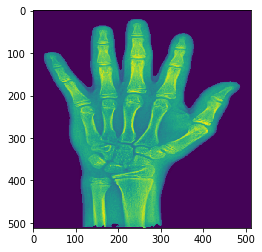

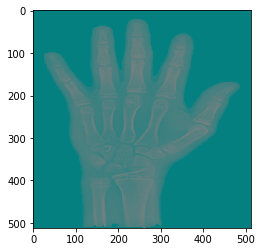

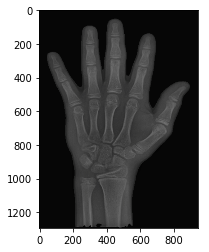

In [40]:
# Testing my image
#orig_images = cv2.imread('train/btrain/1381.png')

ret, gray = cv2.threshold(gray, 200, 255,0)
image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_areas[-1])
mask = np.zeros((512,512),dtype= np.uint8)
cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
roi=image[y-20:y+h+20,x-20:x+w+20]
roi=cv2.resize(roi,(512,512))
plt.imshow(roi)
plt.show()

lab= cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
plt.imshow(lab)
plt.show()
#cv2.imwrite("outputforml/1_lab.png",lab)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)
plt.show()

plt.imshow(a)
plt.show()

plt.imshow(b)

plt.show()
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
plt.imshow( cl)
plt.show()
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)
plt.show()
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
cv2.imwrite('train/outputforimage/final_output.png', cv2.resize(final, (shapey[1], shapey[0])))
plt.imshow(cv2.resize(final, (shapey[1], shapey[0])))
#plt.show()

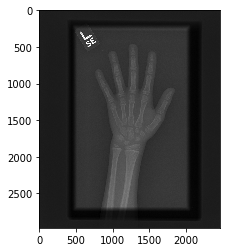

In [16]:
orig_images = cv2.imread('train/btrain/5463.png')

plt.imshow(orig_images)

In [20]:
!mkdir outputforml

In [21]:
!ls

01.png
1378.png
1398.png
1451.png
1511.png
1526.png
1610.png
1901.jpg
1902.jpg
1902.png
1903.jpg
1910.jpg
4189.png
4197.png
4201.png
4204.png
4209.png
4217.png
4221.png
4229.png
4237.png
4248.png
accunet.h5
accunetnew.h5
archive
carvana
carvana.h5
carvana.ipynb
carvanalog
ConvertAllJpgToPNG.ipynb
ConvertSupervisely3imagesinto1.ipynb
Createnewmasks-batch.ipynb
Createnewmasks-Copy1.ipynb
Createnewmasks-Copy2.ipynb
Createnewmasks-Copy3.ipynb
Createnewmasks-Copy4.ipynb
Createnewmasks.ipynb
FAKE BATCH MAKING.ipynb
FindMaskOverlayForInspection-Batch1.ipynb
FindMaskOverlayForInspection.ipynb
Generate all Masks-Copy1.ipynb
Generate all Masks.ipynb
hello.jpg
input.png
log
logs
mask.png
masks
ML CARVANA FAKE.ipynb
ML FAKE UNET.ipynb
modelbatchone.h5
modeltr_b2.h5
modeltr_b3.h5
modeltr.h5
old
outputforml
output.png
plot.png
saved.png
train
trainoriginalunetdatawiththresholding.ipynb
Unet-batches.ipynb
unet-carvana-challenge.ipynb
Unet-Copy1.ipynb
Unet-Copy2.ipynb
Unet.ipynb
unetlog
unet_train
une